# 用于预训练词嵌入的数据集


In [1]:
import math
import os
import random
import torch
from d2l import torch as d2l

## 读取数据集


In [2]:
# 1. 注册数据集到DATA_HUB
#@save
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')
'''
2. 读取PTB数据集函数
    download_extract('ptb')：自动下载ptb.zip并解压，返回解压目录路径
    包含文件：ptb.train.txt, ptb.valid.txt, ptb.test.txt
'''
#@save
def read_ptb():
    """将PTB数据集加载到文本行的列表中"""
    data_dir = d2l.download_extract('ptb')
    # Readthetrainingset.
    # 3. 读取训练文件：打开训练文件并读取全部内容
    # raw_text是一个巨大的字符串，包含所有训练句子，换行符分隔
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    '''
    4. 分割成句子词元列表
        raw_text.split('\n')：按换行符分割，得到句子字符串列表
        示例：["a man is walking","the woman sings",""]（最后一行可能是空）
        line.split()：对每个句子字符串按空格分割成词元
        示例："a man is walking"→ ['a','man','is','walking']
        列表推导式 ：返回嵌套列表，每个元素是一个句子的词元列表
    '''
    return [line.split() for line in raw_text.split('\n')]
'''
5. 加载并统计
    执行函数：调用read_ptb()，下载（首次）并处理数据
    len(sentences)：统计句子总数
    f-string：格式化输出，显示句子数量
'''
sentences = read_ptb()
f'# sentences数: {len(sentences)}'

'# sentences数: 42069'

在读取训练集之后，我们为语料库构建了一个词表，其中出现次数少于10次的任何单词都将由“&lt;unk&gt;”词元替换。请注意，原始数据集还包含表示稀有（未知）单词的“&lt;unk&gt;”词元。


In [3]:
'''
1. 创建词汇表
sentences：PTB训练数据，是嵌套列表结构，如 [['a','man','walks'],['the','woman','sings'],...]
min_freq=10：过滤低频词，只保留出现次数≥10的词元
    减少词汇表大小（从原始约2万降至~6700）
    降低模型参数量
    避免低频词噪声干扰
Vocab内部处理：
    展平句子：将所有词元合并成一个列表
    统计词频：计算每个词的出现次数
    排序去重：按频率排序，构建词表
    添加特殊符号：自动插入<unk>、<pad>等
'''
vocab = d2l.Vocab(sentences, min_freq=10)
# 2. 查看词汇表大小
f'vocab size: {len(vocab)}'

'vocab size: 6719'

## 下采样

$$ P(w_i) = \max\left(1 - \sqrt{\frac{t}{f(w_i)}}, 0\right),$$

其中$f(w_i)$是$w_i$的词数与数据集中的总词数的比率，常量$t$是超参数（在实验中为$10^{-4}$）。我们可以看到，只有当相对比率$f(w_i) > t$时，（高频）词$w_i$才能被丢弃，且该词的相对比率越高，被丢弃的概率就越大。


```python
# 原始句子（高频词'the'、'a'被下采样）
sentences = [
    ['the', 'man', 'walks', 'the', 'dog'],
    ['a', 'woman', 'sings', 'a', 'song']
]

subsampled, counter = subsample(sentences, vocab)

# 结果可能（随机）：
[
    ['man', 'walks', 'dog'],          # 'the'被删除
    ['woman', 'sings', 'song']        # 'a'被删除
]
```

In [4]:
# sentences：嵌套列表[['a','man',...],['the','woman',...],...]
# vocab：词汇表对象，提供unk索引和词元查询
#@save
def subsample(sentences, vocab):
    """下采样高频词"""
    # 排除未知词元'<unk>'
    '''
    2. 排除未知词元
        外层列表推导式：遍历每个句子
        内层列表推导式：过滤掉被标记为<unk>的词元
        目的：<unk>次数极少，保留它们会引入噪声且浪费计算
        vocab[token]：查询词元的索引
        vocab.unk：<unk>的索引（通常是0）
        条件：只保留索引不等于<unk>的词元
    '''
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    # 3. 统计词频
    # counter：字典，记录每个词元在整个语料库中的出现次数
    counter = d2l.count_corpus(sentences)
    # num_tokens：语料库总词元数（所有词出现次数之和）
    num_tokens = sum(counter.values())

    # 如果在下采样期间保留词元，则返回True
    '''
    4. 子采样概率函数
    逻辑：词越高频，被保留的概率越低
    随机数<概率：保留该词元
    随机数>=概率：丢弃该词元
    math.sqrt**：取平方根，使概率下降更平缓
    '''
    def keep(token):
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))
    '''
    5. 应用下采样
    外层列表推导式：遍历每个句子
    内层列表推导式：对每个词元调用keep()，仅保留通过概率测试的词
    返回值：
        subsampled：处理后的句子列表（部分词被删除）
        counter：原始词频统计（后续可能用于负采样计算）
    '''
    return ([[token for token in line if keep(token)] for line in sentences],
            counter)

subsampled, counter = subsample(sentences, vocab)

```txt
          原始 vs 下采样句子长度分布
               # tokens per sentence
   count
     ^
     |                ┌───┐
     |                │   │  ┌───┐
     |             ┌──┘   │  │   │
     |          ┌──┘      └──┘   │
     |       ┌──┘                  │
     |    ┌──┘                     │
     |    │                        │
     +----+------------------------> 句子长度
          原始       下采样
```


| 词       | 出现次数   | f(w\_i) | 计算过程                                      | 保留概率     | 丢弃概率      |
| ------- | ------ | ------- | ----------------------------------------- | -------- | --------- |
| **the** | 50,000 | 5%      | `sqrt(1e-4 / 0.05) = sqrt(0.002) = 0.045` | **4.5%** | **95.5%** |
| **a**   | 30,000 | 3%      | `sqrt(1e-4 / 0.03) = 0.058`               | 5.8%     | 94.2%     |
| **man** | 100    | 0.01%   | `sqrt(1e-4 / 0.0001) = 1.0`               | **100%** | **0%**    |


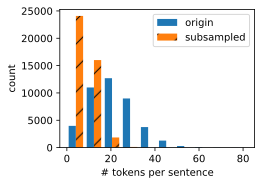

In [5]:
d2l.show_list_len_pair_hist(
    ['origin', 'subsampled'], # 图例标签
    '# tokens per sentence', # X轴标签
    'count', # Y轴标签
    sentences, # 原始数据
    subsampled); # 下采样后数据

对于单个词元，高频词“the”的采样率不到1/20。


In [6]:
def compare_counts(token):
    return (f'"{token}"的数量：'
            '''
            1. 原始语料词频统计
            l.count(token)：统计单个句子l中词元token的出现次数
            for l in sentences：遍历所有原始句子
            sum([...])：将各句子中的次数累加，得到语料库总词频
            '''
            f'之前={sum([l.count(token) for l in sentences])}, '
            '''
            2. 下采样后词频统计
            逻辑同上，但作用于subsampled（下采样后的语料）
            对比同一词元在两个语料库中的总出现次数
            '''
            f'之后={sum([l.count(token) for l in subsampled])}')

compare_counts('the')

'"the"的数量：\n            1. 原始语料词频统计\n            l.count(token)：统计单个句子l中词元token的出现次数\n            for l in sentences：遍历所有原始句子\n            sum([...])：将各句子中的次数累加，得到语料库总词频\n            之前=50770, \n            2. 下采样后词频统计\n            逻辑同上，但作用于subsampled（下采样后的语料）\n            对比同一词元在两个语料库中的总出现次数\n            之后=2037'

相比之下，低频词“join”则被完全保留。


In [7]:
compare_counts('join')
# compare_counts('man')
# compare_counts('algorithm')

'"join"的数量：\n            1. 原始语料词频统计\n            l.count(token)：统计单个句子l中词元token的出现次数\n            for l in sentences：遍历所有原始句子\n            sum([...])：将各句子中的次数累加，得到语料库总词频\n            之前=45, \n            2. 下采样后词频统计\n            逻辑同上，但作用于subsampled（下采样后的语料）\n            对比同一词元在两个语料库中的总出现次数\n            之后=45'

```python
原始句子: "the man walks the dog"
    ↓ tokenize + lower
词元列表: ['the', 'man', 'walks', 'the', 'dog']
    ↓ 过滤<unk>
过滤后: ['the', 'man', 'walks', 'the', 'dog']  # 假设'the'在词表中
    ↓ subsample（丢弃高频'the'）
下采样: ['man', 'walks', 'dog']
    ↓ vocab[...]
索引ID: [245, 1024, 380]
```

In [8]:
'''
1. 词元→索引转换
subsampled：下采样后的嵌套词元列表
vocab[line]：对每个句子中的每个词元，查询其在词汇表中的索引ID
vocab是d2l.Vocab对象，支持列表作为输入
示例：vocab[['man','walks']]→[245,1024]
结果 ：corpus是嵌套的索引列表
'''
corpus = [vocab[line] for line in subsampled]
# 2. 查看前3个样本
corpus[:3]

[[], [71, 392, 2115, 145], [5277, 3054, 1580]]

## 中心词和上下文词的提取

In [9]:
# centers：所有中心词ID，平坦列表（flatten）
# contexts：每个中心词对应的上下文词ID列表的列表
#@save
def get_centers_and_contexts(corpus, max_window_size):
    """返回跳元模型中的中心词和上下文词"""
    centers, contexts = [], []
    for line in corpus:
        # 要形成“中心词-上下文词”对，每个句子至少需要有2个词
        # 1. 过滤过短句子：句子至少要有2个词，否则无法构成"中心词-上下文词"对
        if len(line) < 2:
            continue
        '''
        2. 收集所有中心词
        简单粗暴：将整个句子的所有词元ID依次追加到centers
        示例：line=[245,1024,380]→centers追加[245,1024,380]
        结果：centers=[c1,c2,c3,c4,c5,...]（所有词依次排列）
        '''
        centers += line
        '''
        3. 为每个中心词构建上下文窗口
        随机窗口大小：每次在1到max_window_size之间随机选择，增加模型鲁棒性
        indices：确定窗口内的所有位置索引（含中心词）
            max(0,i-window_size)：左边界，不越界
            min(len(line),i+1+window_size)：右边界（+1是因为range不包含右端点）
        '''
        for i in range(len(line)):  # 上下文窗口中间i
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # 从上下文词中排除中心词
            # 4. 排除中心词：从上下文索引列表中移除中心词自身位置，确保上下文词不等于中心词
            indices.remove(i)
            # 5. 提取上下文词：列表推导式
            # 根据indices中的索引，从句子中提取对应的词元ID，追加到contexts：每个元素是该中心词的上下文词列表
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

接下来，我们创建一个人工数据集，分别包含7个和3个单词的两个句子。设置最大上下文窗口大小为2，并打印所有中心词及其上下文词。


```python
句子: [245, 1024, 380, 501]
       ↓
centers: [245, 1024, 380, 501]

i=0 (中心词245):
  window_size随机=2
  indices = range(max(0, -2), min(4, 0+1+2)) = range(0, 3) = [0, 1, 2]
  indices.remove(0) → [1, 2]
  contexts[0] = [line[1], line[2]] = [1024, 380]

i=1 (中心词1024):
  window_size随机=1
  indices = range(max(0, 0), min(4, 1+1+1)) = range(0, 3) = [0, 1, 2]
  indices.remove(1) → [0, 2]
  contexts[1] = [line[0], line[2]] = [245, 380]

i=2 (中心词380):
  window_size随机=2
  indices = range(max(0, 0), min(4, 2+1+2)) = range(0, 4) = [0, 1, 2, 3]
  indices.remove(2) → [0, 1, 3]
  contexts[2] = [line[0], line[1], line[3]] = [245, 1024, 501]

i=3 (中心词501):
  window_size随机=1
  indices = range(max(0, 2), min(4, 3+1+1)) = range(2, 4) = [2, 3]
  indices.remove(3) → [2]
  contexts[3] = [line[2]] = [380]
```

函数执行过程模拟<br>
句子1: [0, 1, 2, 3, 4, 5, 6]
| 位置i | 中心词 | 假设window\_size | 计算过程                                              | 结果          | 您的输出          |
| --- | --- | -------------- | ------------------------------------------------- | ----------- | ------------- |
| 0   | 0   | **1**          | `range(0, 2)` → `[0,1]` → 移除0 → `[1]`             | `[1]`       | ✅ `[1]`       |
| 1   | 1   | **1**          | `range(0, 3)` → `[0,1,2]` → 移除1 → `[0,2]`         | `[0,2]`     | ✅ `[0,2]`     |
| 2   | 2   | **2**          | `range(0, 5)` → `[0,1,2,3,4]` → 移除2 → `[0,1,3,4]` | `[0,1,3,4]` | ✅ `[0,1,3,4]` |
| 3   | 3   | **1**          | `range(2, 5)` → `[2,3,4]` → 移除3 → `[2,4]`         | `[2,4]`     | ✅ `[2,4]`     |
| 4   | 4   | **1**          | `range(3, 6)` → `[3,4,5]` → 移除4 → `[3,5]`         | `[3,5]`     | ✅ `[3,5]`     |
| 5   | 5   | **1**          | `range(4, 7)` → `[4,5,6]` → 移除5 → `[4,6]`         | `[4,6]`     | ✅ `[4,6]`     |
| 6   | 6   | **1**          | `range(5, 7)` → `[5,6]` → 移除6 → `[5]`             | `[5]`       | ✅ `[5]`       |



句子2: [7, 8, 9]
| 位置i | 中心词 | 假设window\_size | 计算过程                                                                                                                   | 结果      | 您的输出      |
| --- | --- | -------------- | ---------------------------------------------------------------------------------------------------------------------- | ------- | --------- |
| 0   | 7   | **2**          | `range(0, 3)` → `[0,1,2]` → 移除0 → `[1,2]` → `[8,9]`                                                                    | `[8,9]` | ✅ `[8,9]` |
| 1   | 8   | **1**          | `range(0, 3)` → `[0,1,2]` → 移除1 → `[0,2]` → `[7,9]`                                                                    | `[7,9]` | ✅ `[7,9]` |
| 2   | 9   | **1** 或 **2**  | **若=1**: `range(1, 3)` → `[1,2]` → 移除2 → `[1]` → `[8]`<br>**若=2**: `range(0, 3)` → `[0,1,2]` → 移除2 → `[0,1]` → `[7,8]` | `[7,8]` | ✅ `[7,8]` |



In [10]:
'''
1. 创建微型数据集
list(range(7))→[0,1,2,3,4,5,6]（第1个句子，7个词）
list(range(7,10))→[7,8,9]（第2个句子，3个词）
tiny_dataset：[[0,1,2,3,4,5,6],[7,8,9]]
'''
tiny_dataset = [list(range(7)), list(range(7, 10))]
# 2. 打印数据集
print('数据集', tiny_dataset)
'''
3. 调用函数并解压
get_centers_and_contexts(tiny_dataset,2)：生成中心词和上下文
max_window_size=2：上下文窗口最大半径为2
zip(*...)：解包函数返回的两个列表，将对应位置的元素配对
'''
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('中心词', center, '的上下文词是', context)

数据集 [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
中心词 0 的上下文词是 [1]
中心词 1 的上下文词是 [0, 2, 3]
中心词 2 的上下文词是 [0, 1, 3, 4]
中心词 3 的上下文词是 [2, 4]
中心词 4 的上下文词是 [3, 5]
中心词 5 的上下文词是 [3, 4, 6]
中心词 6 的上下文词是 [5]
中心词 7 的上下文词是 [8]
中心词 8 的上下文词是 [7, 9]
中心词 9 的上下文词是 [8]


在PTB数据集上进行训练时，我们将最大上下文窗口大小设置为5。下面提取数据集中的所有中心词及其上下文词。


**为什么是len(all_contexts) 而不是 len(all_centers)？<br>**
all_centers长度=中心词总数（约67万）<br>
all_contexts长度=中心词总数（因为每个中心词对应一个上下文列表）<br>
但实际训练对数=所有上下文列表长度之和 ，因为一个中心词可能对应 多个上下文词。

In [11]:
'''
1. 生成所有中心词和上下文
corpus：索引化后的语料库，如[[245,1024,380],[1123,2045,4519],...]（约5.5万句子，67万词元）
max_window_size=5：上下文窗口最大半径为5（实际随机1~5）
all_centers：平坦列表，包含所有中心词ID（长度≈语料库总词数）
all_contexts：嵌套列表，每个元素是一个中心词的上下文词列表
'''
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
'''
2. 统计总对数
列表推导式：遍历all_contexts中的每个contexts（上下文列表）
len(contexts)：获取每个中心词对应的上下文数量
sum([...])： 累加所有中心词的上下文数量 ，即总词对数
'''
f'# “中心词-上下文词对”的数量: {sum([len(contexts) for contexts in all_contexts])}'

'# “中心词-上下文词对”的数量: 1502474'

## 负采样

我们使用负采样进行近似训练。为了根据预定义的分布对噪声词进行采样，我们定义以下`RandomGenerator`类，其中（可能未规范化的）采样分布通过变量`sampling_weights`传递。


In [12]:
#@save
class RandomGenerator:
    """根据n个采样权重在{1,...,n}中随机抽取"""
    def __init__(self, sampling_weights):
        # Exclude
        '''
        sampling_weights：列表，每个词元的采样权重（词频的3/4次方）
        self.population：所有候选词的索引列表[1,2,3,...,n]
        注意：从1开始（跳过0，因为0通常是<pad>或<unk>）
        self.candidates：缓存池，存储批量生成的样本（初始为空）
        self.i：缓存指针，指向当前返回位置
        '''
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        # 1. 缓存耗尽检测：当指针到达缓存末尾，说明10000个样本已用完
        if self.i == len(self.candidates):
            # 缓存k个随机采样结果
            # 批量生成新缓存：random.choices()：有放回地按权重采样；k=10000：一次生成10000个样本存入缓存
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            # 3. 重置指针：从头开始消费新缓存
            self.i = 0
        # 返回单个样本：指针前移，返回当前位置的样本
        self.i += 1
        return self.candidates[self.i - 1]

例如，我们可以在索引1、2和3中绘制10个随机变量$X$，采样概率为$P(X=1)=2/9, P(X=2)=3/9$和$P(X=3)=4/9$，如下所示。


In [13]:
'''
1. 创建采样器实例
sampling_weights=[2,3,4]：3个词的采样权重
population=[1,2,3]：候选词ID列表
    词ID:1（权重2）
    词ID:2（权重3）
    词ID:3（权重4）
'''
#@save
generator = RandomGenerator([2, 3, 4])
# 2. 抽取10个样本
# 列表推导式：循环10次，每次调用generator.draw()；返回：包含10个采样结果的列表
[generator.draw() for _ in range(10)]

[3, 3, 2, 3, 2, 1, 1, 2, 3, 3]

对于一对中心词和上下文词，我们随机抽取了`K`个（实验中为5个）噪声词。根据word2vec论文中的建议，将噪声词$w$的采样概率$P(w)$设置为其在字典中的相对频率，其幂为0.75


In [14]:
'''
all_contexts:所有中心词的上下文列表
vocab:词汇表对象
counter:词频统计
K:每个正样本的负样本倍数（如5）
'''
#@save
def get_negatives(all_contexts, vocab, counter, K):
    """返回负采样中的噪声词"""
    # 索引为1、2、...（索引0是词表中排除的未知标记）
    '''
    1. 计算采样权重
    range(1,len(vocab))：从索引1开始（跳过0，通常是<pad>或<unk>）
    vocab.to_tokens(i)：将索引转回词元字符串(字典)
    counter[...]：获取该词的出现次数
    **0.75 ：词频的3/4次方，平滑高频词的采样权重
    抑制效应：高频词权重增长变慢，避免过度采样
    '''
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    # 2. 初始化采样器和结果容器：RandomGenerator：按权重高效采样的缓存类；all_negatives：存储所有负样本的列表
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    '''
    3. 遍历每个上下文列表
    contexts：一个中心词对应的所有正上下文词ID列表，如 [245,380,501]
    len(contexts)*K：需要生成的负样本总数（如3×5=15个）
    generator.draw()：按权重采样一个词ID（高频词更易被采到）
    if neg not in contexts：关键过滤，确保负样本不是正样本
    while循环：持续采样直到凑够所需数量的有效负样本
    '''
    for contexts in all_contexts:
        negatives = [] # 存储该中心词对应的负样本列表
        while len(negatives) < len(contexts) * K: # 当负样本数不足时，持续采样
            neg = generator.draw()
            # 噪声词不能是上下文词
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    # 4. 返回结果结构：返回的all_negatives与all_contexts一一对应
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

## 小批量加载训练实例


| 变量                         | 含义                                               | 示例值                                    |
| -------------------------- | ------------------------------------------------ | -------------------------------------- |
| **`data`**                 | 批次的原始数据列表，每个元素是 `(center, context, negative)` 元组 | `[(245, [1024, 380], [3, 1, 2]), ...]` |
| `_`                | 中心词ID（这里用下划线表示暂时忽略）                              | `245`                                  |
| `c`               |  上下文词列表 （正样本）                            | `[1024, 380]`（2个正样本）                   |
| `n`                |  负样本词列表 （噪声词）                            | `[3, 1, 2, 1, 3]`（5个负样本）               |
| `len(c)`         | 正样本数量                                            | `2`                                    |
| `len(n)`          | 负样本数量                                            | `5`                                    |
| `len(c) + len(n)`  | 该样本的总词数（正+负）                             | `7`                                    |


In [15]:
#@save
def batchify(data):
    """返回带有负采样的跳元模型的小批量样本"""
    # data=[(center1,context1,negative1),(center2,context2,negative2),...]
    '''
    1. 计算本批次最大长度
    对每个样本，计算正样本数+负样本数
    取批次中的最大值作为统一长度
    目的：所有样本填充至相同长度，便于矩阵运算
    '''
    max_len = max(len(c) + len(n) for _, c, n in data)
    '''
    2. 初始化批次容器
    centers：中心词ID列表
    contexts_negatives：拼接后的上下文（正+负）+填充0
    masks：标记哪些是真实词，哪些是填充（1=真实，0=填充）
    labels：标记哪些是正样本（1=正，0=负/填充）
    '''
    centers, contexts_negatives, masks, labels = [], [], [], []
    # 3. 遍历每个样本
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        # 4. 收集中心词：每个样本一个中心词；最终形状：(batch_size,1)
        centers += [center]
        '''
        5. 构建输入序列（拼接+填充）
        context+negative：先拼接正样本和负样本
        +[0]*(max_len-cur_len)：用0填充至批次最大长度
        为什么用0？：0通常是<pad>的索引，模型会忽略
        '''
        contexts_negatives += \
            [context + negative + [0] * (max_len - cur_len)]
        '''
        6. 构建掩码（Mask）
        [1]*cur_len：正样本和负样本位置标记为1（有效）
        [0]*(max_len-cur_len)：填充位置标记为0（无效）
        用途：在计算损失时忽略填充部分
        '''
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        '''
        7. 构建标签（Label）
        [1]*len(context)：正样本位置标记为1（目标=1）
        [0]*(max_len-len(context))：负样本和填充位置标记为0（目标=0）
        用途：二元分类标签，区分正/负样本
        '''
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    '''
    8. 转换为tensor并返回
    centers：reshape为(batch_size,1)的二维tensor
    contexts_negatives：(batch_size,max_len)，输入序列
    masks：(batch_size,max_len)，指示有效位置
    labels：(batch_size,max_len)，监督目标
    '''
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

**执行过程**
1. 计算批次最大长度
```Python
max_len = max(len([2,2]) + len([3,3,3,3]), len([2,2,2]) + len([3,3]))
        = max(2+4, 3+2) = max(6, 5) = 6
```
2. 处理x_1（长度=6，无需填充）
```Python
cur_len = 6
centers += [1]                                    # → [1]
contexts_negatives += [[2,2] + [3,3,3,3] + [0]*(6-6)]  # → [[2,2,3,3,3,3]]
masks += [[1]*6 + [0]*0]                          # → [[1,1,1,1,1,1]]
labels += [[1]*2 + [0]*(6-2)]                     # → [[1,1,0,0,0,0]]
```
3. 处理x_2（长度=5，需填充1个0）
```Python
cur_len = 5
centers += [1]                                    # → [1, 1]
contexts_negatives += [[2,2,2] + [3,3] + [0]*(6-5)]    # → [[2,2,3,3,3,3], [2,2,2,3,3,0]]
masks += [[1]*5 + [0]*1]                          # → [[1,1,1,1,1,1], [1,1,1,1,1,0]]
labels += [[1]*3 + [0]*(6-3)]                     # → [[1,1,0,0,0,0], [1,1,1,0,0,0]]
```
**预期输出**
```Python
centers = tensor([[1], [1]])
# 形状: (2, 1)

contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
                             [2, 2, 2, 3, 3, 0]])
# 形状: (2, 6)  (batch_size, max_len)

masks = tensor([[1, 1, 1, 1, 1, 1],
                [1, 1, 1, 1, 1, 0]])
# 形状: (2, 6)  第2个样本最后1个位置是填充

labels = tensor([[1, 1, 0, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0]])
# 形状: (2, 6)  第2个样本多1个正样本
```
**关键验证点**
| 检查项       | x\_1     | x\_2     | 说明               |
| --------- | -------- | -------- | ---------------- |
| **长度**    | 6        | 5        | max\_len=6       |
| **填充位置**  | 无        | 末尾1个0    | 对齐到max\_len      |
| **mask**  | 全1       | 最后1个0    | 标记填充位置           |
| **label** | 2个1, 4个0 | 3个1, 3个0 | 正样本数=实际context长度 |



In [16]:
x_1 = (1, [2, 2], [3, 3, 3, 3]) # 中心词=1,2个正样本,4个负样本
x_2 = (1, [2, 2, 2], [3, 3]) # 中心词=1,3个正样本,2个负样本
batch = batchify((x_1, x_2)) # 将元组传递给batchify

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


## 整合代码

最后，我们定义了读取PTB数据集并返回数据迭代器和词表的`load_data_ptb`函数。


In [ ]:
'''
batch_size:训练批次大小
max_window_size:跳元模型上下文窗口半径
num_noise_words:每个正样本对应的负样本数K
'''
#@save
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """下载PTB数据集，然后将其加载到内存中"""
    # 1. 设置多进程加载
    # num_workers = d2l.get_dataloader_workers()
    num_workers = 0
    # 2. 读取原始语料：读取PTB训练集，返回分词后的嵌套列表
    sentences = read_ptb()
    # 3. 构建词汇表：过滤频次<10的低频词，减少词汇表至约6700词；自动添加<unk>、<pad>等特殊符号
    vocab = d2l.Vocab(sentences, min_freq=10)
    '''
    4. 子采样高频词
    目的：丢弃高频词（如'the','a'），让模型关注低频词
    原理：P(保留)=sqrt(1e-4/f(w))
    结果：'the'出现次数从5万降至约2000
    '''
    subsampled, counter = subsample(sentences, vocab)
    # 5. 转换为索引ID：将词元字符串转为整数索引，便于嵌入层查找
    corpus = [vocab[line] for line in subsampled] # 'man'→245,'walks'→1024,'dog'→380；corpus[0]=[245,1024,380]
    '''
    6. 生成中心词与上下文
    中心词：平坦列表，每个词都作为中心词一次（约67万个）
    上下文：每个中心词对应的正样本列表
    窗口：随机1~max_window_size，例如max=5时平均每个中心词配4.3个上下文
    '''
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    '''
    7. 生成负样本
    采样量：每个正样本配K个负样本（如K=5）
    权重：词频的3/4次方，counter[w]**0.75
    过滤：负样本≠正样本
    结果：约300万负样本（67万正样本×5）
    '''
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)
    # 8. 定义数据集类
    # 继承：torch.utils.data.Dataset，兼容PyTorch数据管道；验证：确保三个列表长度一致
    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives
        # 9. 实现索引访问：返回：(中心词ID,正样本列表,负样本列表)
        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])
        # 10. 实现数据集大小：返回样本总数（约67万）
        def __len__(self):
            return len(self.centers)
    # 11. 创建数据集实例：包装所有训练数据
    dataset = PTBDataset(all_centers, all_contexts, all_negatives)
    '''
    12. 创建数据加载器
    shuffle=True：打乱数据，避免顺序偏见
    collate_fn=batchify：关键！将变长样本整理为定长tensors
    num_workers：多进程加载数据，提升效率
    '''
    data_iter = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True,
        collate_fn=batchify, num_workers=num_workers)
    '''
    13. 返回结果
    data_iter：可迭代的训练数据，每个批次包含(centers,contexts_negatives,masks, labels)
    vocab：词汇表对象，后续可能用于词向量查询或评测
    '''
    return data_iter, vocab

让我们打印数据迭代器的第一个小批量。


In [20]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])
